In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset path
dataset_path = r"/home/ubuntu/CODE/PRATAPY/dataset-classification/bagus"

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50
train_split = 0.8
val_split = 0.2

# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=transform_train)
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {full_dataset.classes}")
print(f"Total images: {len(full_dataset)}")

# Split dataset
train_size = int(train_split * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms to validation set
val_dataset.dataset.transform = transform_val

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Define CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize model, loss function, and optimizer
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_path = 'best_model.pth'
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')
        
        scheduler.step()
    
    return train_losses, val_losses, train_accuracies, val_accuracies


Using device: cuda
Number of classes: 2
Classes: ['birch', 'elm']
Total images: 100
Training samples: 80
Validation samples: 20


Starting training...
Epoch [1/50], Batch [0/3], Loss: 0.6860
Epoch [1/50]:
Train Loss: 0.8262, Train Acc: 62.50%
Val Loss: 0.6137, Val Acc: 70.00%
--------------------------------------------------
New best model saved with validation accuracy: 70.00%
Epoch [2/50], Batch [0/3], Loss: 0.4875
Epoch [2/50]:
Train Loss: 0.7922, Train Acc: 85.00%
Val Loss: 0.9707, Val Acc: 65.00%
--------------------------------------------------
Epoch [3/50], Batch [0/3], Loss: 1.2751
Epoch [3/50]:
Train Loss: 0.6846, Train Acc: 77.50%
Val Loss: 1.2523, Val Acc: 70.00%
--------------------------------------------------
Epoch [4/50], Batch [0/3], Loss: 0.3733
Epoch [4/50]:
Train Loss: 0.3512, Train Acc: 86.25%
Val Loss: 0.9224, Val Acc: 75.00%
--------------------------------------------------
New best model saved with validation accuracy: 75.00%
Epoch [5/50], Batch [0/3], Loss: 0.4099
Epoch [5/50]:
Train Loss: 0.4484, Train Acc: 86.25%
Val Loss: 0.8334, Val Acc: 70.00%
-------------------------------------

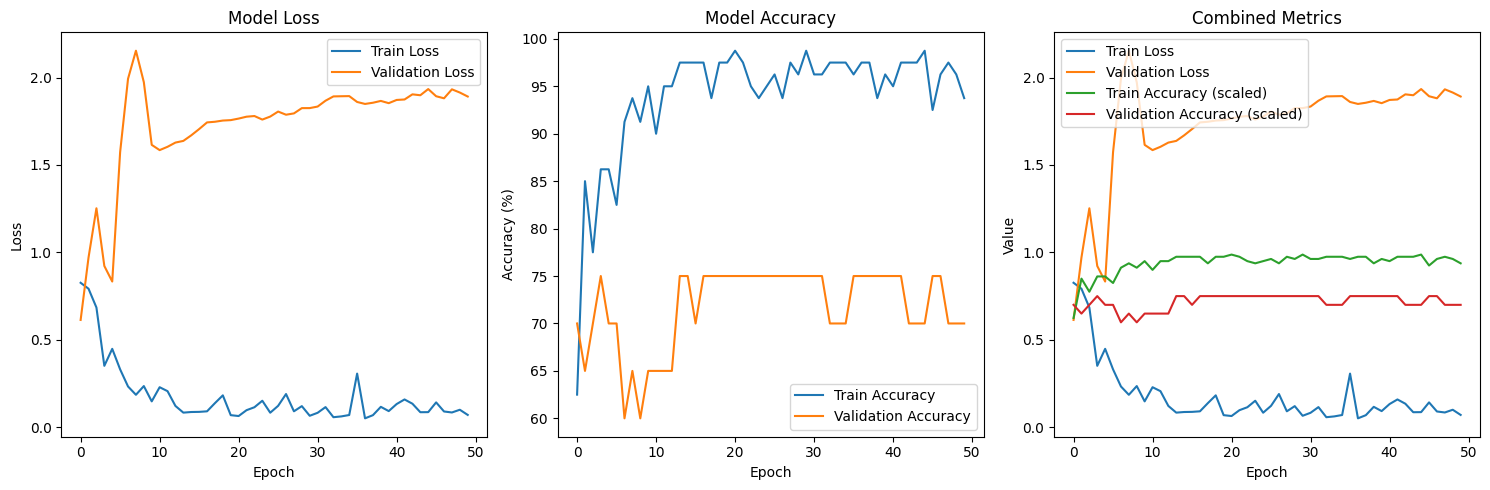

Evaluating model on validation set...

Classification Report:
              precision    recall  f1-score   support

       birch       0.88      0.64      0.74        11
         elm       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



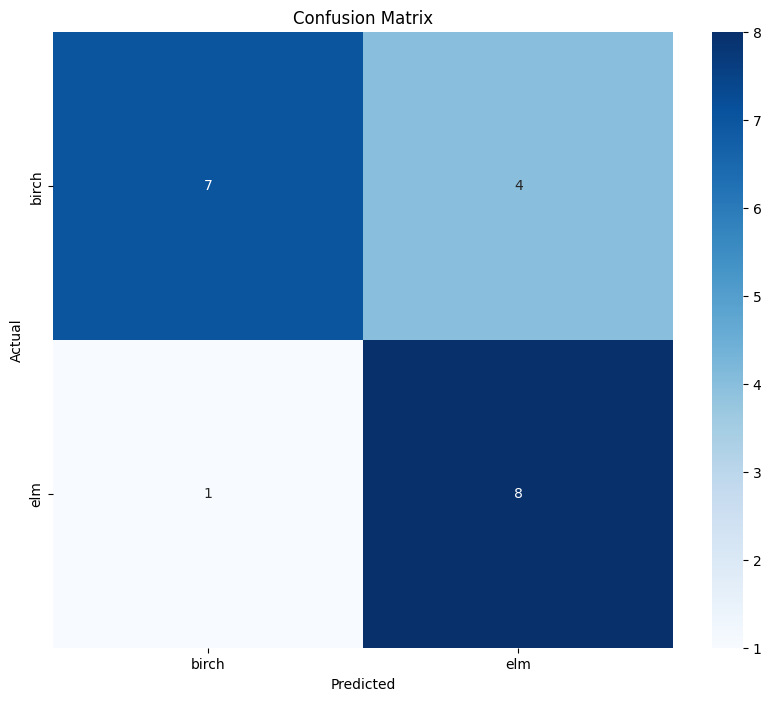


Training completed!
Best model saved as: best_model.pth
Final model saved as: final_model_20250706_111219.pth
Training history plot saved as: training_history.png
Confusion matrix saved as: confusion_matrix.png

To predict a single image, use:
predicted_class, confidence = predict_image(model, 'path/to/image.jpg', transform_val, full_dataset.classes)
print(f'Predicted: {predicted_class} with confidence: {confidence:.2f}')


In [ ]:
# Training
print("Starting training...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(np.array(train_accuracies)/100, label='Train Accuracy (scaled)')
plt.plot(np.array(val_accuracies)/100, label='Validation Accuracy (scaled)')
plt.title('Combined Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Load best model for evaluation
model.load_state_dict(torch.load('best_model
                                 h'))
model.eval()

# Evaluation function
def evaluate_model(model, data_loader, class_names):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return all_predictions, all_targets

# Evaluate on validation set
print("Evaluating model on validation set...")
val_predictions, val_targets = evaluate_model(model, val_loader, full_dataset.classes)

# Save final model
final_model_path = f'final_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': full_dataset.classes,
    'num_classes': num_classes,
    'model_architecture': 'CNN'
}, final_model_path)

print(f"\nTraining completed!")
print(f"Best model saved as: best_model.pth")
print(f"Final model saved as: {final_model_path}")
print(f"Training history plot saved as: training_history.png")
print(f"Confusion matrix saved as: confusion_matrix.png")

# Function to predict single image
def predict_image(model, image_path, transform, class_names):
    from PIL import Image
    
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        
        confidence = probabilities[predicted_class].item()
    
    return class_names[predicted_class], confidence

# Example usage for prediction
print("\nTo predict a single image, use:")
print("predicted_class, confidence = predict_image(model, 'path/to/image.jpg', transform_val, full_dataset.classes)")
print(f"print(f'Predicted: {{predicted_class}} with confidence: {{confidence:.2f}}')")

In [4]:
predicted_class, confidence = predict_image(model, '/home/ubuntu/CODE/PRATAPY/dataset-classification/bagus/birch/tree9.jpg', transform_val, full_dataset.classes)
print(f'Predicted: {predicted_class} with confidence: {confidence:.2f}')

Predicted: birch with confidence: 0.95


In [5]:
# Save full model (less flexible but simpler)
torch.save(model, 'cnn_model_full.pt')


In [ ]:
# after training:
torch.save(model.state_dict(), "cnn_state_dict.pth")

In [ ]:
# Save the model as ONNX
torch.onnx.export(model, torch.randn(1, 3, 224, 224).to(device), "cnn_model.onnx", export_params=True)
